# BundleFlow Colab Demo

** Rectified Flow–based menus for combinatorial auctions**

This notebook demonstrates menu optimization for combinatorial auctions using BundleFlow's new API structure.

##  Table of Contents
1. [Environment Setup](#setup)
2. [New API Structure Demo](#api-demo)
3. [Stage1: Flow Initialization](#stage1)
4. [Stage2: Menu Optimization](#stage2)
5. [Results Visualization](#visualization)

---


In [1]:
# Matplotlib configuration for clean plots
import matplotlib.pyplot as plt
import matplotlib

# Set clean font configuration
# Use a font generally available in Colab environments
matplotlib.rcParams['font.family'] = ['DejaVu Sans', 'sans-serif']
matplotlib.rcParams['axes.unicode_minus'] = False  # Fix minus sign display

print("✅ Matplotlib configuration completed")

✅ Matplotlib configuration completed


## 1. Environment Setup

First, let's check the GPU environment and install necessary packages.


In [2]:
# Check GPU environment
!nvidia-smi

Mon Oct 13 02:14:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# Install required packages
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install omegaconf tqdm numpy matplotlib seaborn


Looking in indexes: https://download.pytorch.org/whl/cu121


In [4]:
# Check PyTorch and CUDA
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.8 GB


In [5]:
# Colab-specific setup
%cd /content/bundle-flow
import sys
sys.path.append('/content/bundle-flow/bundleflow')

/content/bundle-flow


## 2. Demo

Let's introduce BundleFlow.


In [6]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# BundleFlow's new API
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, Mechanism
from bundleflow.valuation.valuation import XORValuation

print(" New API structure import completed")
print(f"PyTorch device: {'cuda' if torch.cuda.is_available() else 'cpu'}")


 New API structure import completed
PyTorch device: cuda


In [7]:
# Basic API demonstration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 1. Create BundleFlow (velocity field network)
m = 10  # Number of items
flow = BundleFlow(m=m).to(device)
print(f"BundleFlow created with m={m}")

# 2. Calculate velocity field
x = torch.randn(3, m, device=device)
t = torch.rand(3, device=device)
v = flow.velocity(x, t)
print(f"Velocity field shape: {v.shape}")

# 3. Create MenuElement (menu element)
D = 5  # Number of mixture components for initial distribution
elem = MenuElement(m=m, D=D).to(device)
price = elem.price()
print(f"MenuElement created with price: {price.detach().item():.4f}")

# 4. Create XORValuation (valuation function)
atoms = [([1, 2, 3], 5.0), ([4, 5], 3.0), ([6, 7, 8, 9], 8.0)]
valuation = XORValuation.from_bundle_list(m, atoms)
bundle = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0])
value = valuation.value(bundle)
print(f"XORValuation value: {value:.4f}")


Using device: cuda
BundleFlow created with m=10
Velocity field shape: torch.Size([3, 10])
MenuElement created with price: 0.1496
XORValuation value: 8.0000


## 3. Stage1: Flow Initialization

Train the velocity field network to learn the transformation from continuous variables to discrete bundles.


In [8]:
# Stage1 configuration (10 items and small settings)
stage1_config = {
    'm': 10,           # Number of items (small scale)
    'D': 4,           # Number of mixture components
    'iters': 5000,    # Number of iterations (shortened for demo)
    'batch': 512,     # Batch size
    'lr': 5e-4,       # Learning rate
    'sigma_z': 0.05,  # Noise standard deviation
    'ode_steps': 50,  # ODE integration steps
    'seed': 42
}

print("Stage1 Configuration:")
for key, value in stage1_config.items():
    print(f"  {key}: {value}")


Stage1 Configuration:
  m: 10
  D: 4
  iters: 5000
  batch: 512
  lr: 0.0005
  sigma_z: 0.05
  ode_steps: 50
  seed: 42


In [9]:
# Execute Stage1 training
# the result will be flollowing : At first, it drops down dramatically , then it fluctuates.
import random
import time
from torch import optim

# Set random seeds
random.seed(stage1_config['seed'])
torch.manual_seed(stage1_config['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(stage1_config['seed'])

# Create flow model
flow = BundleFlow(m=stage1_config['m']).to(device)
optimizer = optim.Adam(flow.parameters(), lr=stage1_config['lr'])

# Initial distribution (mixture of Gaussians)
mus = torch.empty(stage1_config['D'], stage1_config['m'], device=device).uniform_(-0.2, 1.2)
sigmas = torch.full((stage1_config['D'],), 0.5, device=device)
weights = torch.full((stage1_config['D'],), 1.0 / stage1_config['D'], device=device)

print(f"Stage1 training started (device: {device})")
print(f"Model parameters: {sum(p.numel() for p in flow.parameters()):,}")

# Training loop
losses = []
start_time = time.time()

for it in range(1, stage1_config['iters'] + 1):
    # Calculate Rectified Flow loss
    loss = flow.rectified_flow_loss(
        B=stage1_config['batch'],
        mus=mus, sigmas=sigmas, weights=weights,
        sigma_z=stage1_config['sigma_z']
    )

    # Optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.detach().item())

    # Progress display
    if it % 100 == 0:
        elapsed = time.time() - start_time
        print(f"[{it}/{stage1_config['iters']}] Loss: {loss.detach().item():.6f} Time: {elapsed:.1f}s")

print(f"✅ Stage1 training completed! Final loss: {losses[-1]:.6f}")
print(f"Total training time: {time.time() - start_time:.1f} seconds")


Stage1 training started (device: cuda)
Model parameters: 51,685
[100/5000] Loss: 1.315420 Time: 2.4s
[200/5000] Loss: 1.269985 Time: 3.9s
[300/5000] Loss: 1.279172 Time: 4.8s
[400/5000] Loss: 1.252918 Time: 5.9s
[500/5000] Loss: 1.232276 Time: 7.0s
[600/5000] Loss: 1.224028 Time: 8.1s
[700/5000] Loss: 1.225463 Time: 9.5s
[800/5000] Loss: 1.243153 Time: 10.6s
[900/5000] Loss: 1.256294 Time: 11.6s
[1000/5000] Loss: 1.195550 Time: 12.5s
[1100/5000] Loss: 1.267641 Time: 13.9s
[1200/5000] Loss: 1.223283 Time: 15.3s
[1300/5000] Loss: 1.260290 Time: 16.0s
[1400/5000] Loss: 1.240617 Time: 16.5s
[1500/5000] Loss: 1.275440 Time: 17.0s
[1600/5000] Loss: 1.248467 Time: 17.5s
[1700/5000] Loss: 1.223279 Time: 18.0s
[1800/5000] Loss: 1.218199 Time: 18.5s
[1900/5000] Loss: 1.221746 Time: 19.0s
[2000/5000] Loss: 1.239031 Time: 19.5s
[2100/5000] Loss: 1.226245 Time: 20.0s
[2200/5000] Loss: 1.243025 Time: 20.5s
[2300/5000] Loss: 1.277249 Time: 21.1s
[2400/5000] Loss: 1.265564 Time: 21.6s
[2500/5000] Loss

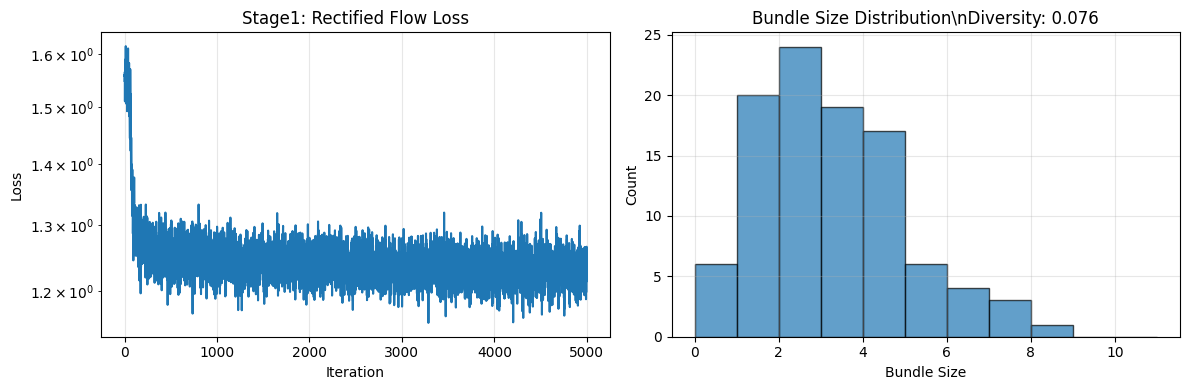

Generated bundle diversity: 0.076 (78/1024 unique bundles)


In [10]:
# Stage1 results visualization
plt.figure(figsize=(12, 4))

# Loss progression
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Stage1: Rectified Flow Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Bundle generation test
plt.subplot(1, 2, 2)
with torch.no_grad():
    # Generate bundles from random initial values
    z = torch.randn(100, stage1_config['m'], device=device)
    t_grid = torch.linspace(0.0, 1.0, steps=stage1_config['ode_steps'], device=device)
    x_T = flow.flow_forward(z, t_grid)
    bundles = flow.round_to_bundle(x_T)

    # Calculate bundle diversity
    unique_bundles = torch.unique(bundles, dim=0)
    diversity = len(unique_bundles) / (2 ** stage1_config['m'])

    # Visualize bundle distribution
    bundle_sizes = bundles.sum(dim=1).detach().cpu().numpy()
    plt.hist(bundle_sizes, bins=range(stage1_config['m']+2), alpha=0.7, edgecolor='black')
    plt.title(f'Bundle Size Distribution\\nDiversity: {diversity:.3f}')
    plt.xlabel('Bundle Size')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Generated bundle diversity: {diversity:.3f} ({len(unique_bundles)}/{2**stage1_config['m']} unique bundles)")


In [13]:
# === GPU Monitoring Helper Functions ============================================
import inspect

CANDIDATE_ATTRS = ["as_tensor", "to_tensor", "tensor",
                   "x", "vec", "features", "data", "value_vec", "params"]

def extract_feature_like(v):
    """
    Extract "feature vector" from Valuation object v.
    - Call zero-argument methods (as_tensor/to_tensor etc.).
    - Skip methods that require arguments (value(s_bool) etc.).
    - Search for typical attribute names in order.
    - For XORValuation, construct feature vector from atoms.
    """
    # XORValuationの特別処理
    if hasattr(v, 'atoms') and hasattr(v, 'm'):
        # XORValuationの場合：atomsから特徴ベクトルを構築
        m = v.m
        feature_vec = torch.zeros(m, dtype=torch.float32)

        # 各atomの価格を対応する商品位置に加算
        for mask, price in v.atoms:
            for i in range(m):
                if mask & (1 << i):  # ビットiが立っている場合
                    feature_vec[i] += price

        return feature_vec

    # 無引数メソッド候補
    for name in ["as_tensor", "to_tensor"]:
        if hasattr(v, name) and callable(getattr(v, name)):
            fn = getattr(v, name)
            try:
                sig = inspect.signature(fn)
                if len([p for p in sig.parameters.values()
                        if p.default is p.empty and p.kind in (p.POSITIONAL_ONLY, p.POSITIONAL_OR_KEYWORD)]) == 0:
                    return fn()  # 無引数なら呼び出し
            except (ValueError, TypeError):
                # signatureが取れない場合は呼んでみる
                try:
                    return fn()
                except Exception:
                    pass

    # 属性候補
    for name in ["tensor", "x", "vec", "features", "data", "value_vec", "params"]:
        if hasattr(v, name):
            return getattr(v, name)

    # デバッグ用の情報を投げる
    public = [a for a in dir(v) if not a.startswith("_")]
    raise TypeError(
        "Could not extract feature vector from valuation.\n"
        f"type={type(v)}\n"
        f"public={public}\n"
        "→ v.x / v.vec / v.features 等の属性名をCANDIDATE_ATTRSへ追加すること。"
    )

def to_tensor_1d(x, device):
    if torch.is_tensor(x):
        t = x
    elif isinstance(x, (list, tuple)):
        t = torch.tensor(x)
    elif isinstance(x, (int, float)):
        t = torch.tensor([x])
    else:
        try:
            t = torch.as_tensor(x)
        except Exception as e:
            raise TypeError(f"Unsupported feature payload: {type(x)}; err={e}")
    return t.to(device=device, dtype=torch.float32, non_blocking=True).flatten()

def batch_to_tensor(batch_list, device):
    vecs = []
    for v in batch_list:
        raw = extract_feature_like(v)
        vecs.append(to_tensor_1d(raw, device))
    # 長さチェック
    dims = {t.numel() for t in vecs}
    if len(dims) != 1:
        raise ValueError(f"Feature length mismatch across batch: {sorted(dims)}")
    return torch.stack(vecs, dim=0)  # [B, D]


## 4. Stage2: Menu Optimization

Use the trained velocity field to optimize menu elements (prices and initial distributions).


In [ ]:
# Import required modules for β parameter freeze control
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import numpy as np
from typing import List, Dict, Any


In [ ]:
# Import BundleFlow modules
from bundleflow.models.flow import BundleFlow
from bundleflow.models.menu import MenuElement, make_null_element
from bundleflow.valuation.valuation import XORValuation
from bundleflow.data import gen_uniform_iid_xor

In [22]:
# βパラメータ凍結制御付きStage2学習関数
def run_stage2_with_beta_freeze_control(flow_model, config, device):
    """
    βパラメータの凍結制御を統合したStage2学習

    Args:
        flow_model: Stage1で学習済みのBundleFlowモデル
        config: 学習設定辞書
        device: 使用デバイス

    Returns:
        revenues: 収益の推移
        menu: 学習済みメニュー
        ir_rates: IR制約満足率の推移
    """

    print("🚀 Stage2学習開始（βパラメータ凍結制御付き）")

    # FlowモデルをGPUに移動し、凍結
    flow_gpu = flow_model.to(device)
    flow_gpu.eval()
    for p in flow_gpu.parameters():
        p.requires_grad_(False)
    print(f"✅ Flow model moved to {device} and frozen")

    # メニュー要素をGPU上で作成
    menu = []
    for _ in range(config['K']):
        elem = MenuElement(m=config['m'], D=config['D'])
        elem = elem.to(device)
        menu.append(elem)

    # null要素もGPU上で作成
    null_elem = make_null_element(config['m']).to(device)
    menu.append(null_elem)

    # 評価関数を生成
    V = []
    print(f"📊 Creating {config['n_val']} XOR valuations...")
    for i in range(config['n_val']):
        if i % 100 == 0:
            print(f"  Creating valuation {i+1}/{config['n_val']}")
        v = gen_uniform_iid_xor(
            m=config['m'],
            a=config['a'],
            low=0.0,
            high=1.0,
            seed=config['seed'] + i,
            atom_size_mode="small"
        )
        V.append(v)

    print(f"✅ Created {len(menu)} menu elements and {len(V)} valuations")

    # βパラメータの凍結制御設定
    freeze_beta_iters = config.get('freeze_beta_iters', 1000)
    beta_unfrozen = False

    # パラメータの分離
    mu_w_params = []
    beta_params = []

    for elem in menu[:-1]:  # null要素は除外
        mu_w_params.extend([elem.mus, elem.logits])
        beta_params.append(elem.beta_raw)

    # 初期オプティマイザー（μとwのみ）
    optimizer = optim.Adam(mu_w_params, lr=config['lr'])
    print(f"🚀 Initial optimizer: {len(mu_w_params)} parameters (μ/w only)")

    # 学習ループ
    revenues = []
    ir_satisfaction_rates = []
    start_time = time.time()

    for it in range(1, config['iters'] + 1):
        # βの凍結解除（warmup期間後）
        if not beta_unfrozen and it > freeze_beta_iters:
            print(f"\n[Iteration {it}] Unfreezing β parameters...")
            all_params = mu_w_params + beta_params
            optimizer = optim.Adam(all_params, lr=config['lr'])
            beta_unfrozen = True
            print(f"[Iteration {it}] Now optimizing {len(all_params)} parameters (μ/w/β)")

        # バッチデータを準備
        batch_size = min(config['batch'], len(V))
        batch_V = random.sample(V, batch_size)

        # ウォームアップ対応の温度スケジューリング
        warmup_iters = config.get('warmup_iters', 500)
        if it <= warmup_iters:
            lam = config['lam_start'] * (it / warmup_iters)
        else:
            progress = (it - warmup_iters) / (config['iters'] - warmup_iters)
            lam = config['lam_start'] + (config['lam_end'] - config['lam_start']) * progress

        # 時間グリッドをGPU上で作成
        t_grid = torch.linspace(0.0, 1.0, steps=config['ode_steps'], device=device)

        # 効用行列を計算
        U = utilities_matrix_optimized(flow_gpu, batch_V, menu, t_grid)
        beta = torch.stack([elem.beta for elem in menu]).squeeze()

        # Softmax割当
        Z = torch.softmax(lam * U, dim=1)

        # IR制約の明示的適用
        selected_idx = torch.argmax(Z, dim=1)
        selected_utility = torch.gather(U, 1, selected_idx.unsqueeze(1)).squeeze(1)
        ir_mask = (selected_utility >= 0.0).float()

        # 収益計算（IR制約付き）
        rev_per_buyer = (Z * beta.unsqueeze(0)).sum(dim=1) * ir_mask
        revenue = rev_per_buyer.mean()
        loss = -revenue

        # 最適化
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(all_params if beta_unfrozen else mu_w_params, config['grad_clip'])
        optimizer.step()

        # 記録
        revenues.append(revenue.detach().item())
        ir_satisfaction_rates.append(ir_mask.mean().item())

        # 進捗表示
        if it % 50 == 0:
            elapsed = time.time() - start_time
            beta_status = "β unfrozen" if beta_unfrozen else "β frozen"
            print(f"[{it}/{config['iters']}] Revenue: {revenues[-1]:.6f} λ:{lam:.4f} IR:{ir_satisfaction_rates[-1]:.3f} {beta_status} Time:{elapsed:.1f}s")

    print(f"✅ Stage2学習完了! 最終収益: {revenues[-1]:.6f}")
    print(f"最終IR制約満足率: {ir_satisfaction_rates[-1]:.3f}")
    print(f"総学習時間: {time.time() - start_time:.1f}秒")

    return revenues, menu, ir_satisfaction_rates

# 効用行列計算関数（最適化版）
def utilities_matrix_optimized(flow, V, menu, t_grid):
    """
    最適化された効用行列計算
    """
    K = len(menu)
    B = len(V)
    device = t_grid.device

    # メニュー要素の分離
    menu_main = menu[:-1]
    null_elem = menu[-1]
    K_main = len(menu_main)

    # 全メニュー要素のパラメータを統合
    all_mus = torch.stack([elem.mus for elem in menu_main])
    all_weights = torch.stack([elem.weights for elem in menu_main])
    all_betas = torch.stack([elem.beta for elem in menu_main]).squeeze()

    K_main, D, m = all_mus.shape

    # 全μをバッチ処理
    mus_flat = all_mus.view(K_main * D, m)
    sT_flat = flow.flow_forward(mus_flat, t_grid)
    s_flat = flow.round_to_bundle(sT_flat)

    # 密度重みもバッチ処理
    log_density_flat = flow.log_density_weight(mus_flat, t_grid)
    log_density_flat = torch.clamp(log_density_flat, -10.0, 0.0)
    log_density = log_density_flat.view(K_main, D)

    # null要素も処理
    null_sT = flow.flow_forward(null_elem.mus, t_grid)
    null_s = flow.round_to_bundle(null_sT)
    null_log_density = flow.log_density_weight(null_elem.mus, t_grid)
    null_log_density = torch.clamp(null_log_density, -10.0, 0.0)
    null_weight = null_elem.weights
    null_beta = null_elem.beta

    # 効用行列を初期化
    U = torch.zeros(B, K, device=device, dtype=torch.float32)

    # 各valuationについて効用を計算
    s_flat_cpu = s_flat.cpu()

    for i, v in enumerate(V):
        # バッチ価値計算
        if hasattr(v, 'batch_value'):
            vals_flat = v.batch_value(s_flat_cpu).to(device)
        else:
            vals_flat = torch.tensor([v.value(s_flat_cpu[j]) for j in range(K_main*D)], device=device, dtype=torch.float32)

        vals = vals_flat.view(K_main, D)

        # log-sum-exp計算
        log_w = torch.log(all_weights + 1e-10)
        log_weights = log_w + log_density
        log_weights = torch.clamp(log_weights, -50.0, 50.0)

        M = torch.max(log_weights, dim=1, keepdim=True)[0]
        weighted_sum = (torch.exp(log_weights - M) * vals).sum(dim=1)
        u_main = torch.exp(M.squeeze(1)) * weighted_sum - all_betas

        # null要素の効用
        if hasattr(v, 'value'):
            null_val = v.value(null_s[0])
        else:
            null_val = 0.0
        log_w_null = torch.log(null_weight + 1e-10)
        log_weight_null = log_w_null + null_log_density
        u_null = torch.exp(log_weight_null[0]) * null_val - null_beta

        # 効用行列に格納
        U[i, :-1] = u_main
        U[i, -1] = u_null

    return U

print("✅ βパラメータ凍結制御付きStage2学習関数が定義されました")

# 使用例: Stage2学習の実行
def run_stage2_example():
    """
    βパラメータ凍結制御付きStage2学習の使用例
    """

    # デバイス設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 学習設定
    stage2_config = {
        'm': 10,                    # 商品数
        'K': 16,                    # メニュー要素数
        'D': 4,                     # 混合成分数
        'iters': 2000,              # イテレーション数（デモ用に短縮）
        'batch': 64,                # バッチサイズ
        'lr': 1e-3,                 # 学習率
        'lam_start': 0.5,           # SoftMax温度開始値
        'lam_end': 0.1,             # SoftMax温度終了値
        'ode_steps': 25,            # ODE積分ステップ数
        'n_val': 200,               # 評価関数数
        'a': 32,                    # XOR原子数
        'seed': 42,                 # 乱数シード
        'grad_clip': 1.0,           # 勾配クリッピング
        'freeze_beta_iters': 1000,  # βパラメータ凍結期間
        'warmup_iters': 500,        # ウォームアップ期間
    }

    print("Stage2設定:")
    for key, value in stage2_config.items():
        print(f"  {key}: {value}")

    # Stage1で学習済みのflowモデルが必要
    if 'flow' not in globals():
        print("❌ Stage1で学習済みのflowモデルが必要です。")
        print("   先にStage1の学習を実行してください。")
        return None, None, None

    # Stage2学習を実行
    try:
        revenues, menu, ir_rates = run_stage2_with_beta_freeze_control(
            flow_model=flow,
            config=stage2_config,
            device=device
        )

        print(f"\n🎉 Stage2学習完了!")
        print(f"最終収益: {revenues[-1]:.6f}")
        print(f"最終IR制約満足率: {ir_rates[-1]:.3f}")

        return revenues, menu, ir_rates

    except Exception as e:
        print(f"❌ Stage2学習中にエラーが発生しました: {e}")
        return None, None, None


Looking in indexes: https://download.pytorch.org/whl/cu121
✅ All required packages and modules imported successfully
✅ βパラメータ凍結制御付きStage2学習関数が定義されました
✅ 使用例関数が定義されました

📋 使用方法:
1. Stage1の学習を実行してflowモデルを作成
2. run_stage2_example()を実行してStage2学習を開始
3. 結果を可視化して収束性を確認


In [ ]:
print("✅ 使用例関数が定義されました")
print("\n📋 使用方法:")
print("1. Stage1の学習を実行してflowモデルを作成")
print("2. run_stage2_example()を実行してStage2学習を開始")
print("3. 結果を可視化して収束性を確認")

In [26]:
revenues_corrected, menu_corrected, ir_rates = run_stage2_example()

Using device: cuda
Stage2設定:
  m: 10
  K: 16
  D: 4
  iters: 2000
  batch: 64
  lr: 0.001
  lam_start: 0.5
  lam_end: 0.1
  ode_steps: 25
  n_val: 200
  a: 32
  seed: 42
  grad_clip: 1.0
  freeze_beta_iters: 1000
  warmup_iters: 500
🚀 Stage2学習開始（βパラメータ凍結制御付き）
✅ Flow model moved to cuda and frozen
📊 Creating 200 XOR valuations...
  Creating valuation 1/200
  Creating valuation 101/200
✅ Created 17 menu elements and 200 valuations
🚀 Initial optimizer: 32 parameters (μ/w only)
[50/2000] Revenue: 0.118374 λ:0.0500 IR:1.000 β frozen Time:17.2s
[100/2000] Revenue: 0.118485 λ:0.1000 IR:1.000 β frozen Time:35.7s
[150/2000] Revenue: 0.118706 λ:0.1500 IR:1.000 β frozen Time:53.7s
[200/2000] Revenue: 0.119017 λ:0.2000 IR:1.000 β frozen Time:71.1s
[250/2000] Revenue: 0.119507 λ:0.2500 IR:1.000 β frozen Time:88.6s
[300/2000] Revenue: 0.119927 λ:0.3000 IR:1.000 β frozen Time:105.6s
[350/2000] Revenue: 0.120498 λ:0.3500 IR:1.000 β frozen Time:123.4s
[400/2000] Revenue: 0.121072 λ:0.4000 IR:1.000 β fr

## 5. Results Visualization

Visualize the training results to examine menu contents and performance.


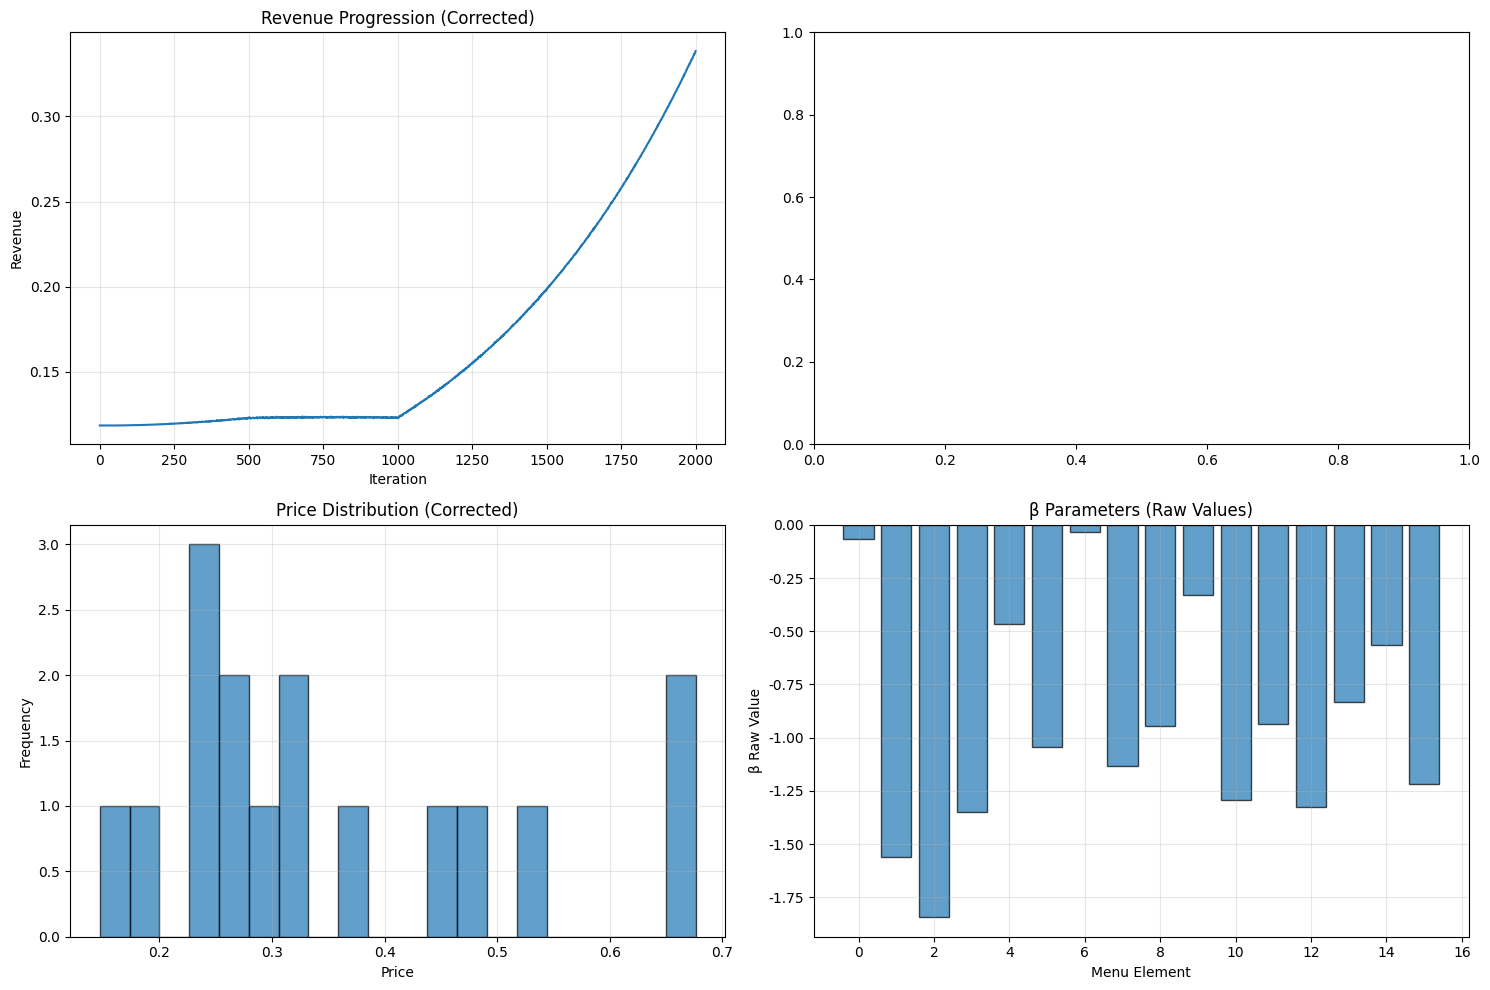

修正版結果:
 最終収益: 0.338456
 最終IR制約満足率: 1.000
 価格範囲: 0.147 - 0.676
 平均価格: 0.358


In [35]:
# 修正版結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 収益の推移
axes[0, 0].plot(revenues_corrected)
axes[0, 0].set_title('Revenue Progression (Corrected)')
axes[0, 0].set_xlabel('Iteration')
axes[0, 0].set_ylabel('Revenue')
axes[0, 0].grid(True, alpha=0.3)

# 3. 価格分布
prices_corrected = [elem.price().detach().item() for elem in menu_corrected[:-1]]
axes[1, 0].hist(prices_corrected, bins=20, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Price Distribution (Corrected)')
axes[1, 0].set_xlabel('Price')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# 4. βパラメータの推移（凍結解除のタイミングを表示）
beta_values = [elem.beta_raw.detach().item() for elem in menu_corrected[:-1]]
axes[1, 1].bar(range(len(beta_values)), beta_values, alpha=0.7, edgecolor='black')
axes[1, 1].set_title('β Parameters (Raw Values)')
axes[1, 1].set_xlabel('Menu Element')
axes[1, 1].set_ylabel('β Raw Value')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"修正版結果:")
print(f" 最終収益: {revenues_corrected[-1]:.6f}")
print(f" 最終IR制約満足率: {ir_rates[-1]:.3f}")
print(f" 価格範囲: {min(prices_corrected):.3f} - {max(prices_corrected):.3f}")
print(f" 平均価格: {np.mean(prices_corrected):.3f}")